# Synthetic Data Quality Analysis

This notebook performs a comprehensive analysis of the synthetic car rental data generated using SDV (Synthetic Data Vault). We will:

1. Load and inspect the synthetic data
2. Evaluate data quality using SDV metrics
3. Compare distributions between sample and synthetic data
4. Analyze correlations and relationships
5. Identify optimization opportunities for better synthetic data generation

**Goal**: Ensure our synthetic data is realistic enough for training a "book or wait" prediction model.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from pathlib import Path

# SDV imports
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.single_table import (
    KSComplement, 
    TVComplement, 
    CorrelationSimilarity,
    CategoricalCAP,
    BoundaryAdherence,
    RangeCoverage
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(2025)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Synthetic and Sample Data

In [2]:
# Define data paths
base_path = Path("..")
synthetic_path = base_path / "data" / "synthetic_data"
sample_path = base_path / "data" / "sample"

# Load all synthetic tables
synthetic_data = {}
synthetic_files = [
    "synthetic_users.csv",
    "synthetic_searches.csv",
    "synthetic_bookings.csv",
    "synthetic_rental_prices.csv",
    "synthetic_competitor_prices.csv",
    "synthetic_locations.csv",
    "synthetic_suppliers.csv",
    "synthetic_car_classes.csv"
]

for file in synthetic_files:
    if (synthetic_path / file).exists():
        table_name = file.replace("synthetic_", "").replace(".csv", "")
        synthetic_data[table_name] = pd.read_csv(synthetic_path / file)
        print(f"✅ Loaded {table_name}: {synthetic_data[table_name].shape}")

# Load sample data (if available)
sample_data = {}
sample_files = [
    "users.csv",
    "searches.csv",
    "bookings.csv",
    "rental_prices.csv",
    "competitor_prices.csv"
]

for file in sample_files:
    if (sample_path / file).exists():
        table_name = file.replace("sample_", "").replace(".csv", "")
        sample_data[table_name] = pd.read_csv(sample_path / file)
        print(f"✅ Loaded sample {table_name}: {sample_data[table_name].shape}")

✅ Loaded users: (20000, 3)
✅ Loaded searches: (57282, 11)
✅ Loaded bookings: (3205, 16)
✅ Loaded rental_prices: (8761, 10)
✅ Loaded competitor_prices: (366, 7)
✅ Loaded locations: (50, 3)
✅ Loaded suppliers: (92, 4)
✅ Loaded car_classes: (4, 3)
✅ Loaded sample users: (20000, 3)
✅ Loaded sample searches: (57282, 11)
✅ Loaded sample bookings: (3205, 16)
✅ Loaded sample rental_prices: (8761, 10)
✅ Loaded sample competitor_prices: (366, 7)


## 2. Data Overview and Basic Statistics

In [3]:
def analyze_table_statistics(data, table_name):
    """Generate comprehensive statistics for a table."""
    print(f"\n{'='*60}")
    print(f"Table: {table_name.upper()}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"\nShape: {data.shape}")
    print(f"Memory usage: {data.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Data types
    print("\nData types:")
    print(data.dtypes.value_counts())
    
    # Missing values
    missing = data.isnull().sum()
    if missing.any():
        print("\nMissing values:")
        print(missing[missing > 0])
    else:
        print("\n✅ No missing values")
    
    # Numeric columns statistics
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("\nNumeric columns statistics:")
        print(data[numeric_cols].describe())
    
    # Categorical columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("\nCategorical columns unique values:")
        for col in categorical_cols:
            print(f"  {col}: {data[col].nunique()} unique values")

# Analyze each synthetic table
for table_name, data in synthetic_data.items():
    analyze_table_statistics(data, table_name)


Table: USERS

Shape: (20000, 3)
Memory usage: 0.46 MB

Data types:
int64     2
object    1
Name: count, dtype: int64

✅ No missing values

Numeric columns statistics:
            user_id  home_location_id
count  2.000000e+04      20000.000000
mean   8.315696e+06          1.586600
std    4.843531e+06          1.376152
min    5.700000e+02          1.000000
25%    4.099368e+06          1.000000
50%    8.262026e+06          1.000000
75%    1.250349e+07          1.000000
max    1.677690e+07          9.000000

Categorical columns unique values:
  segment: 5 unique values

Table: SEARCHES

Shape: (57282, 11)
Memory usage: 4.81 MB

Data types:
object    6
int64     5
Name: count, dtype: int64

✅ No missing values

Numeric columns statistics:
            user_id   location_id     search_id          hour         month
count  57282.000000  57282.000000  5.728200e+04  57282.000000  57282.000000
mean   12908.565623     11.513250  8.389200e+06     14.657868      7.420568
std     3728.228941      7.

## 3. Distribution Comparison: Synthetic vs Sample Data

We'll compare the distributions of key features between synthetic and sample data (where available).



Comparing USERS


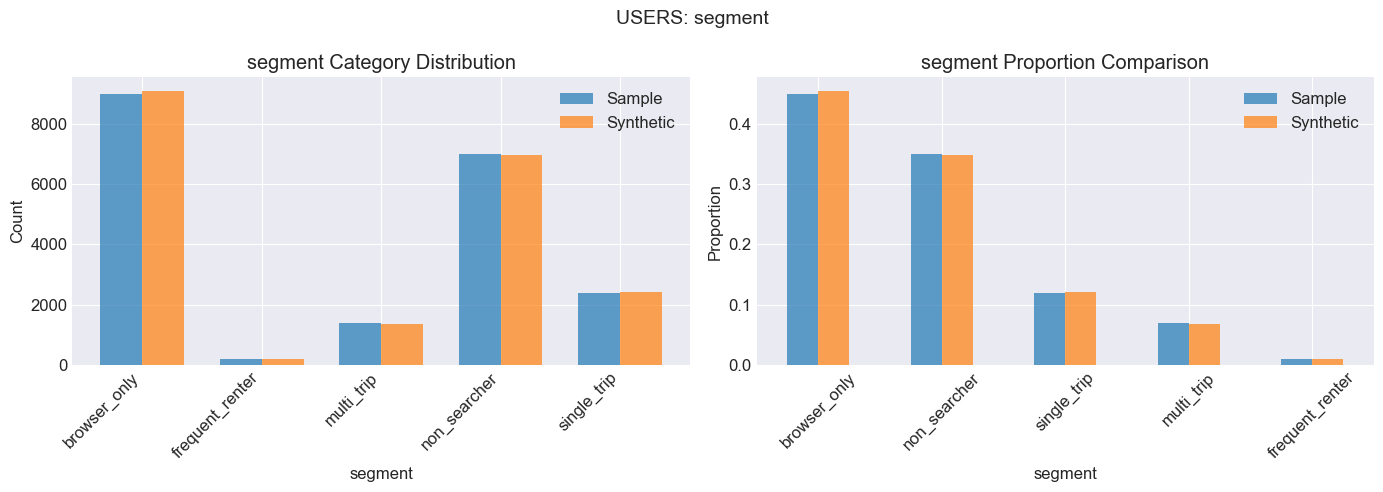

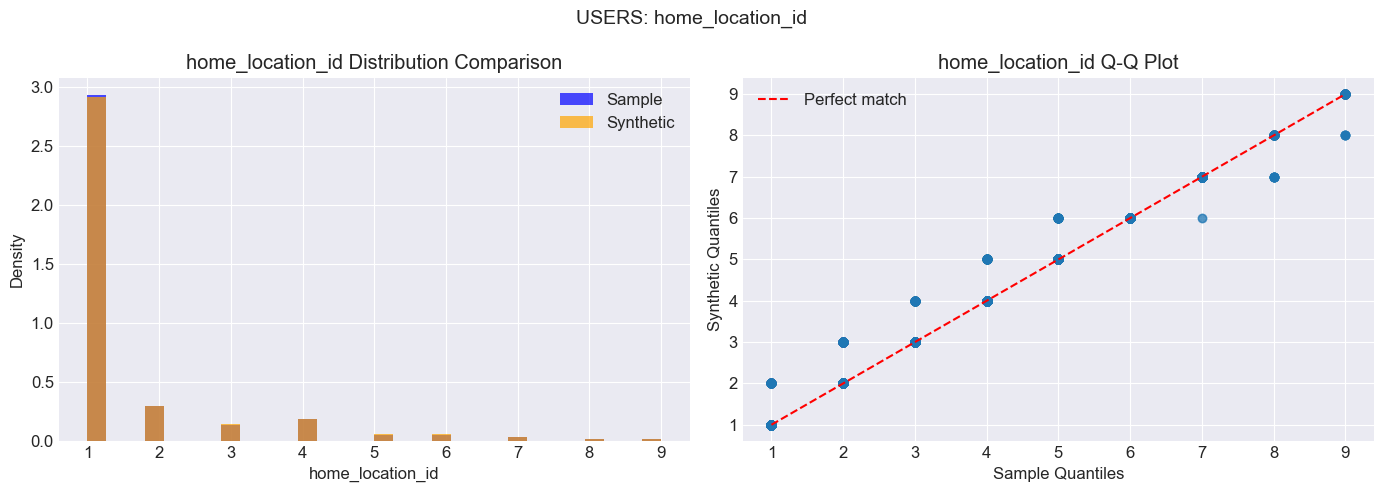

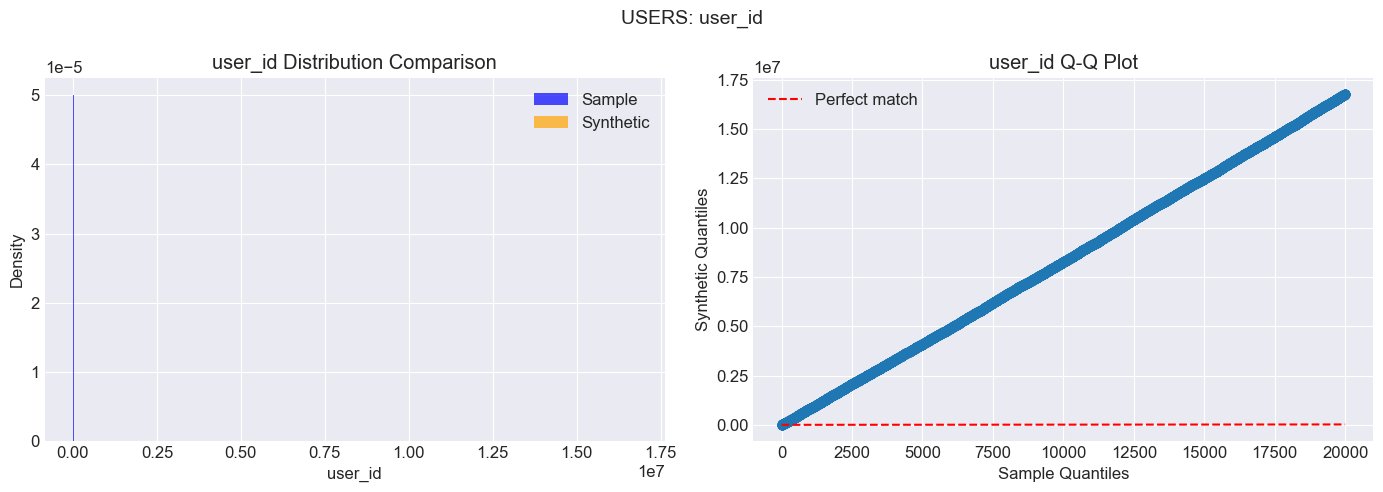



Comparing SEARCHES


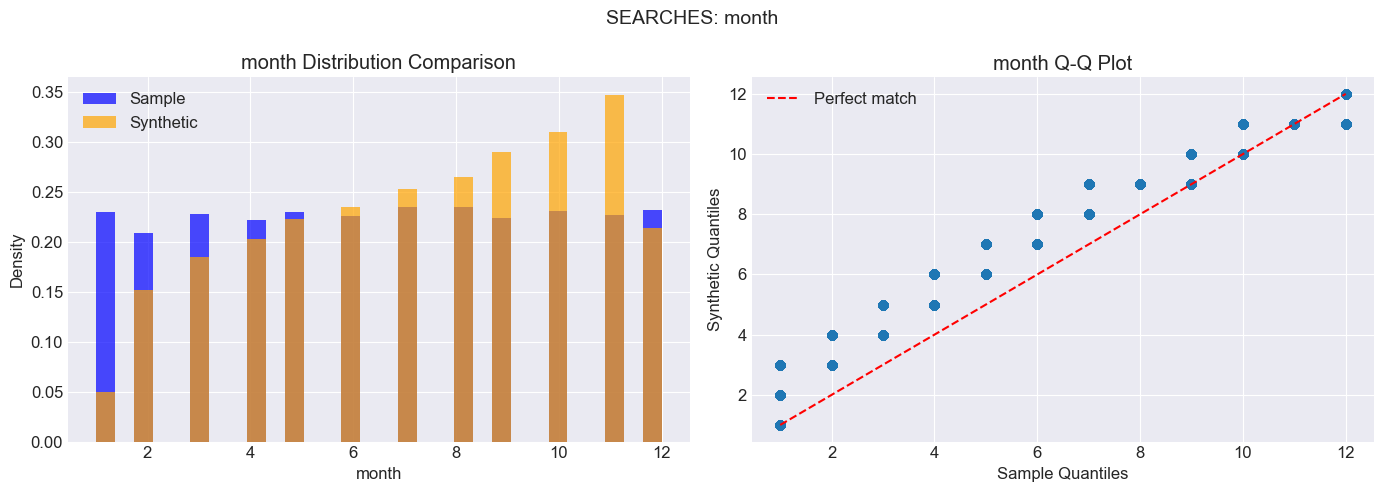

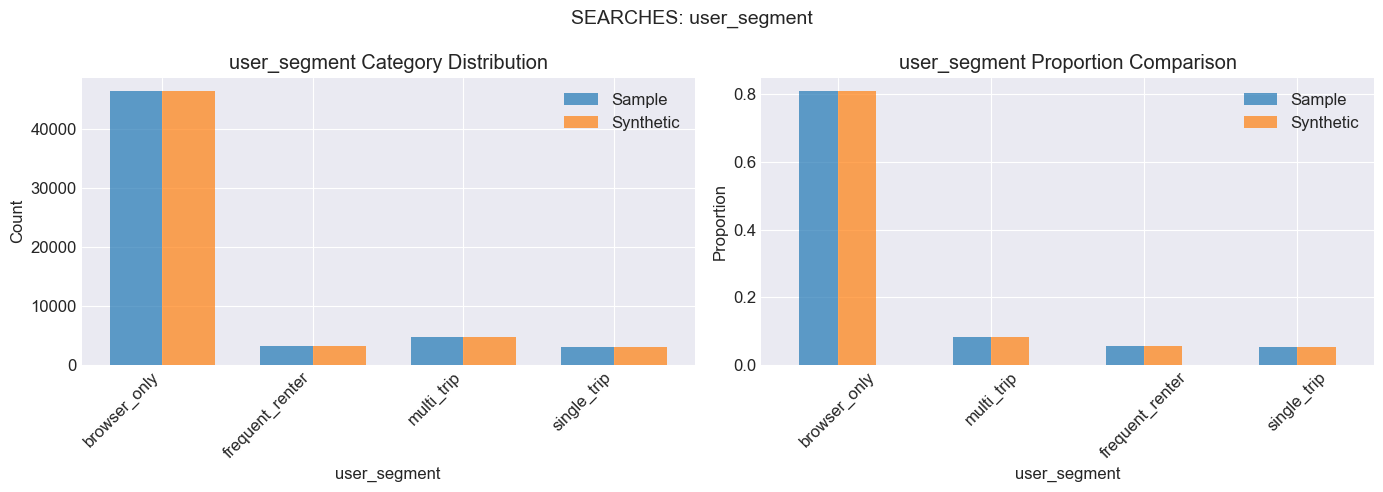

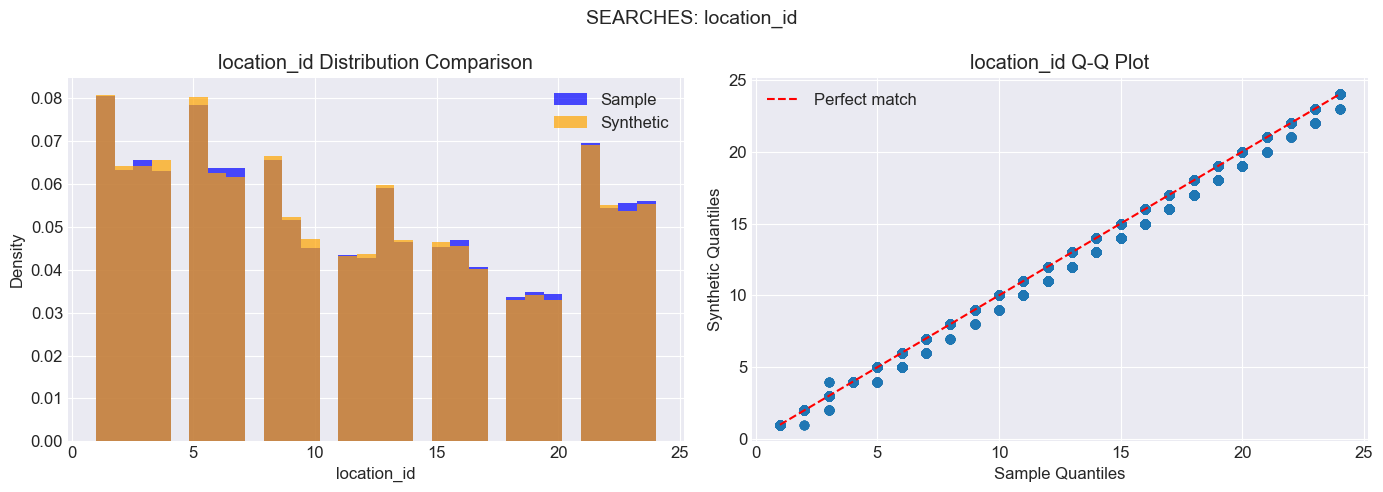



Comparing BOOKINGS


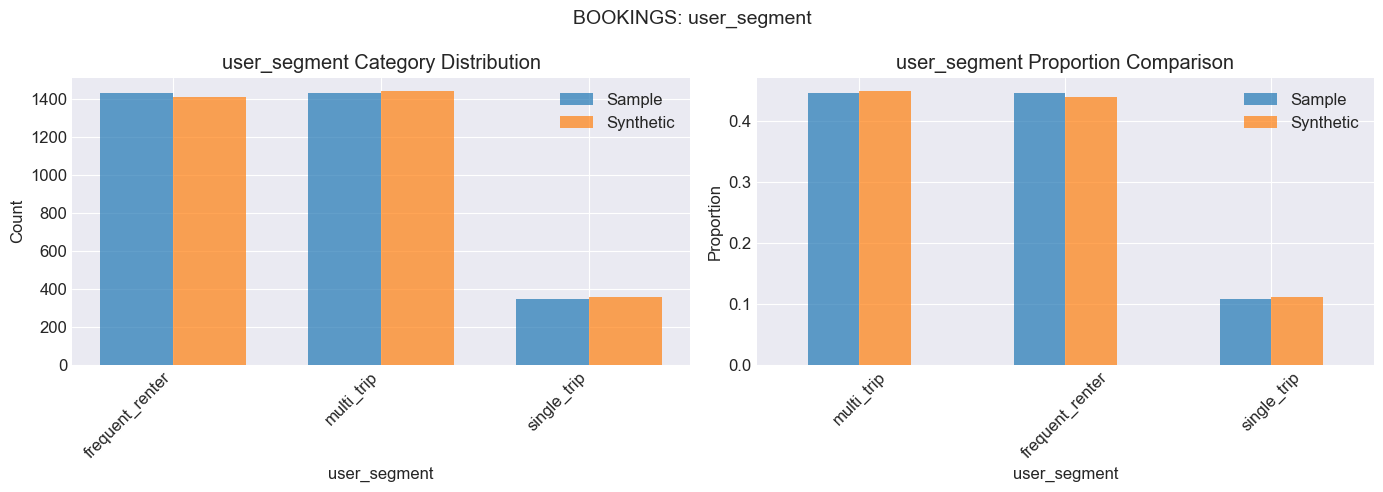

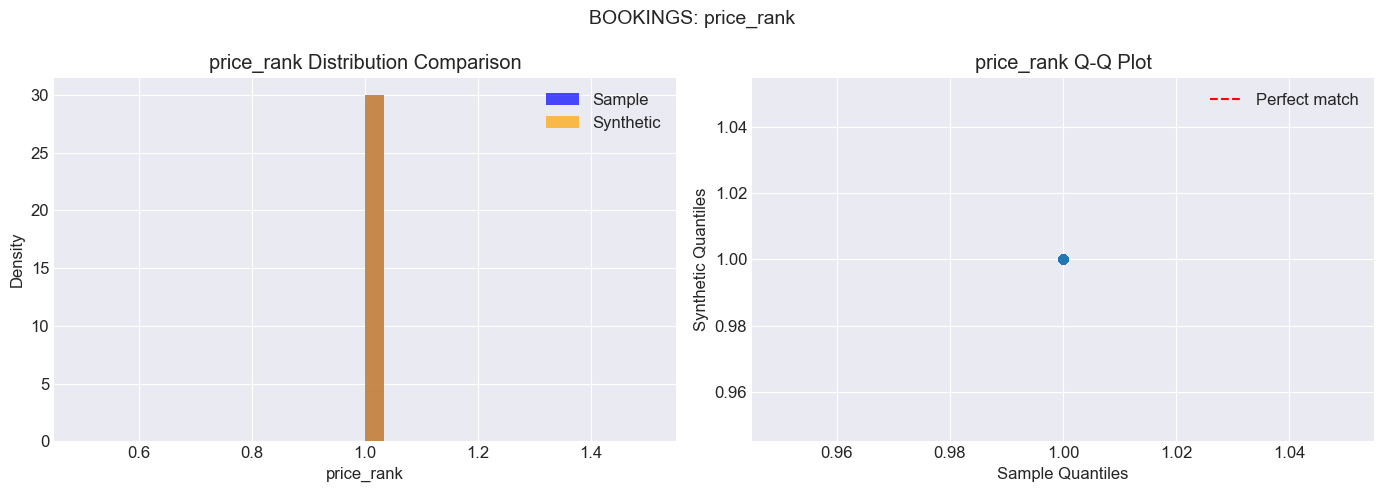

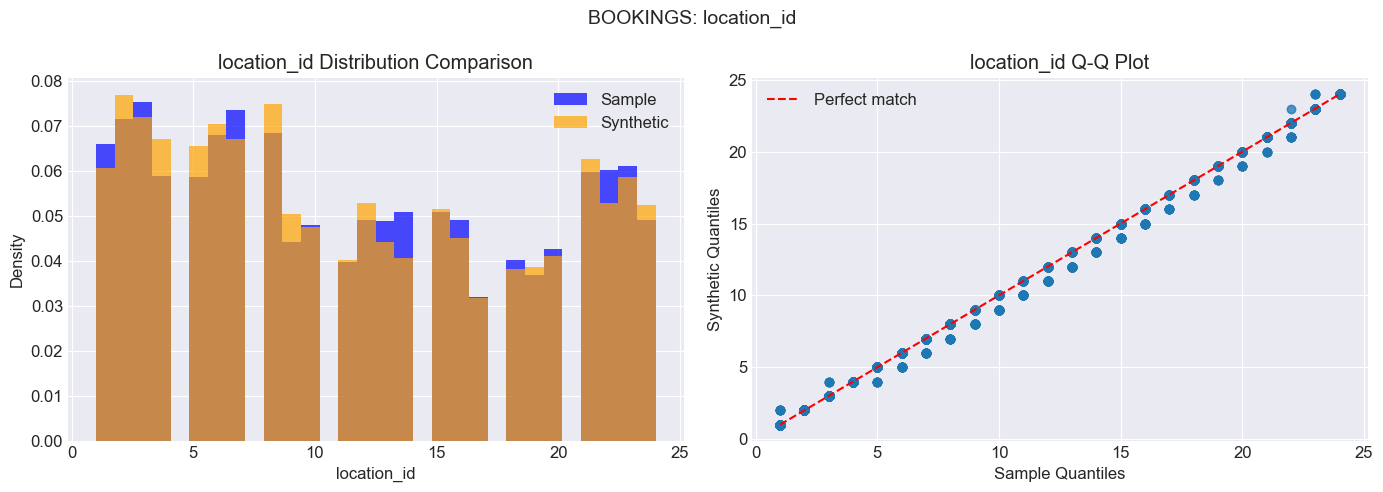



Comparing RENTAL_PRICES


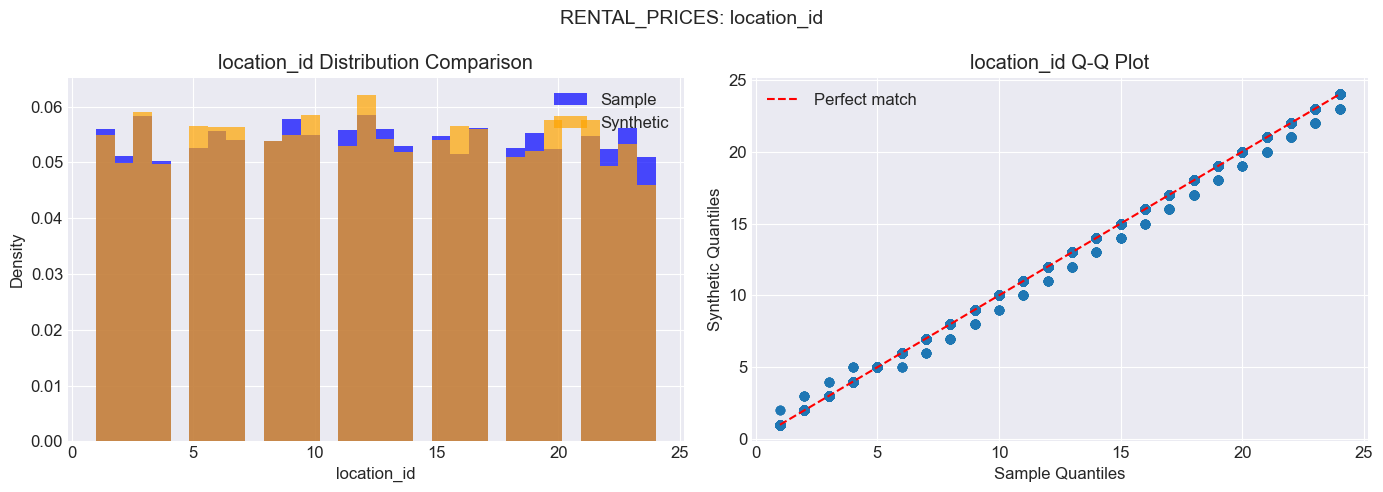

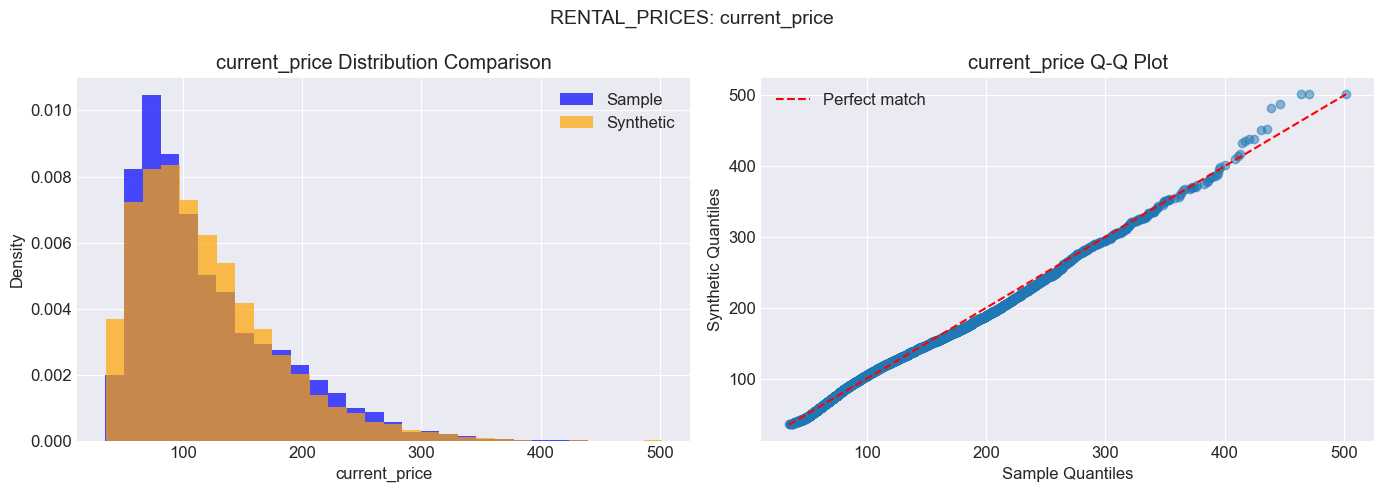

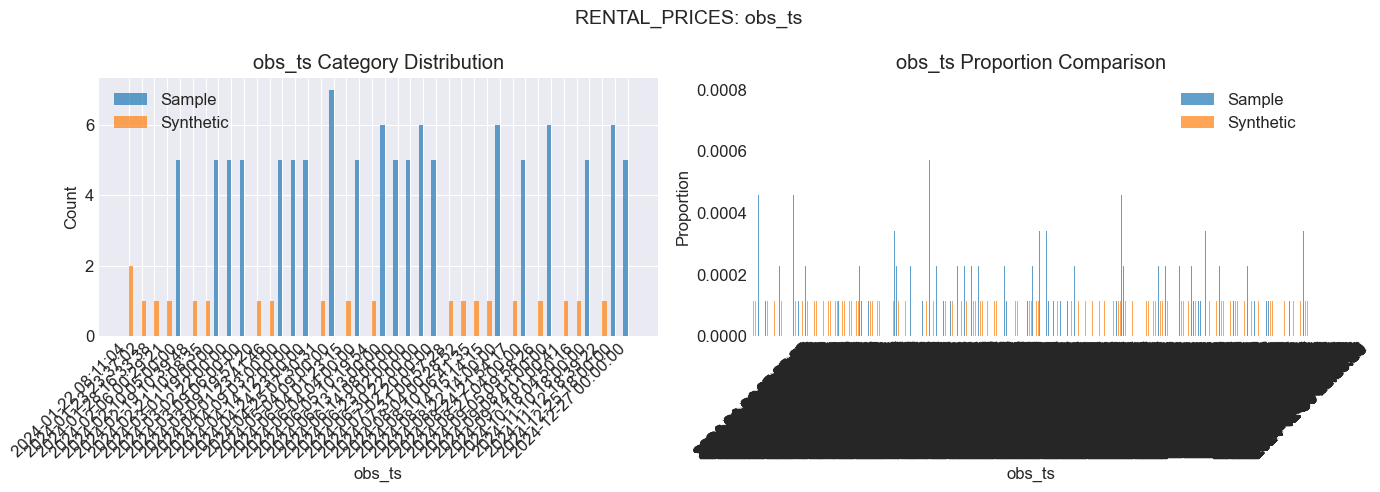



Comparing COMPETITOR_PRICES


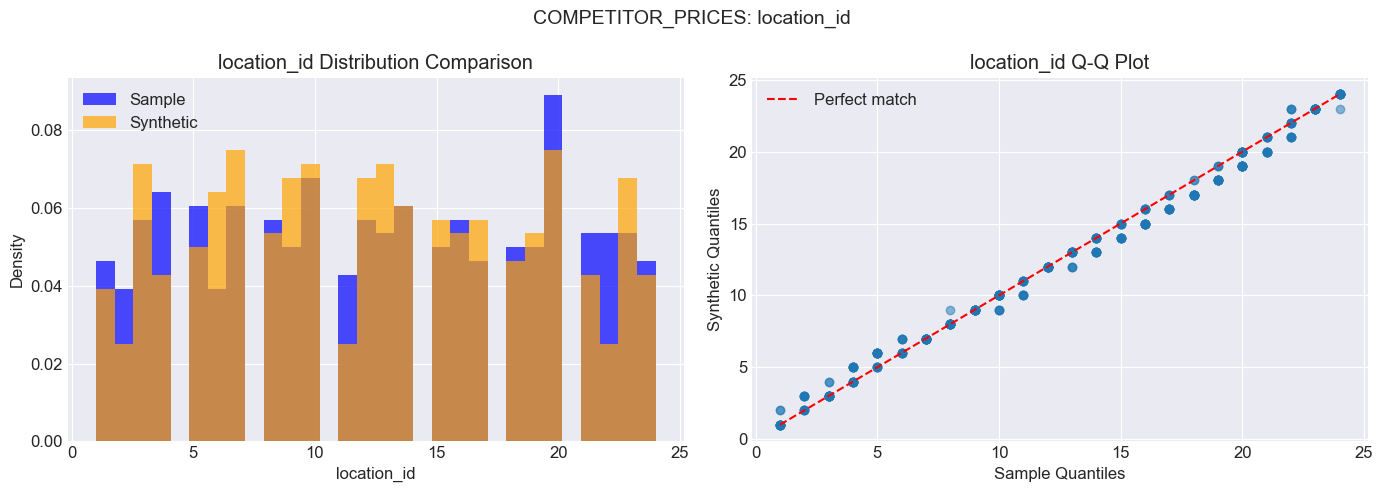

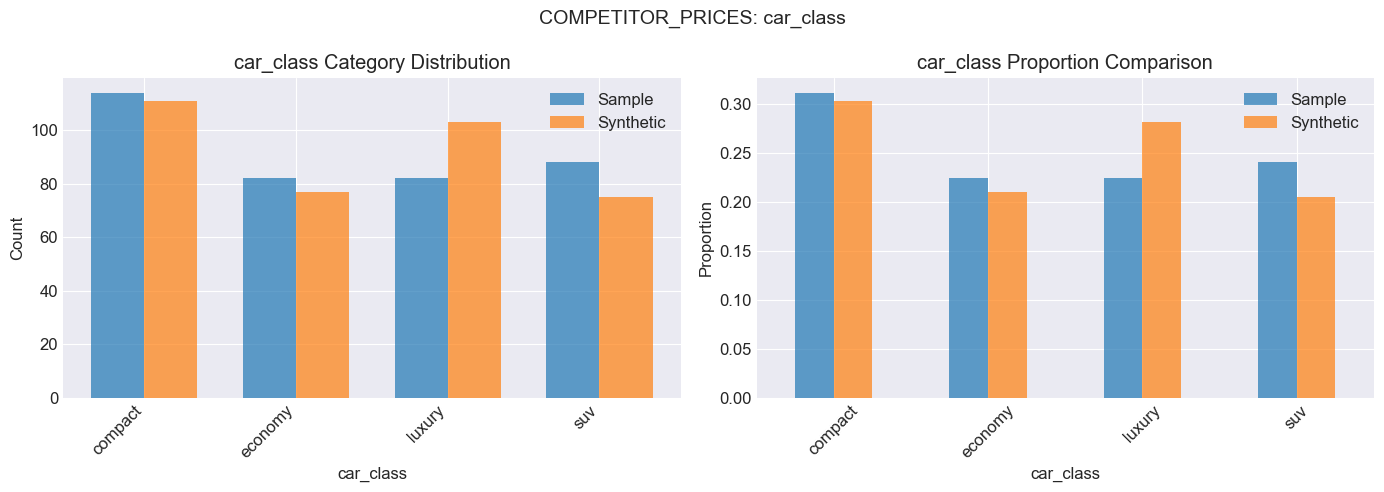

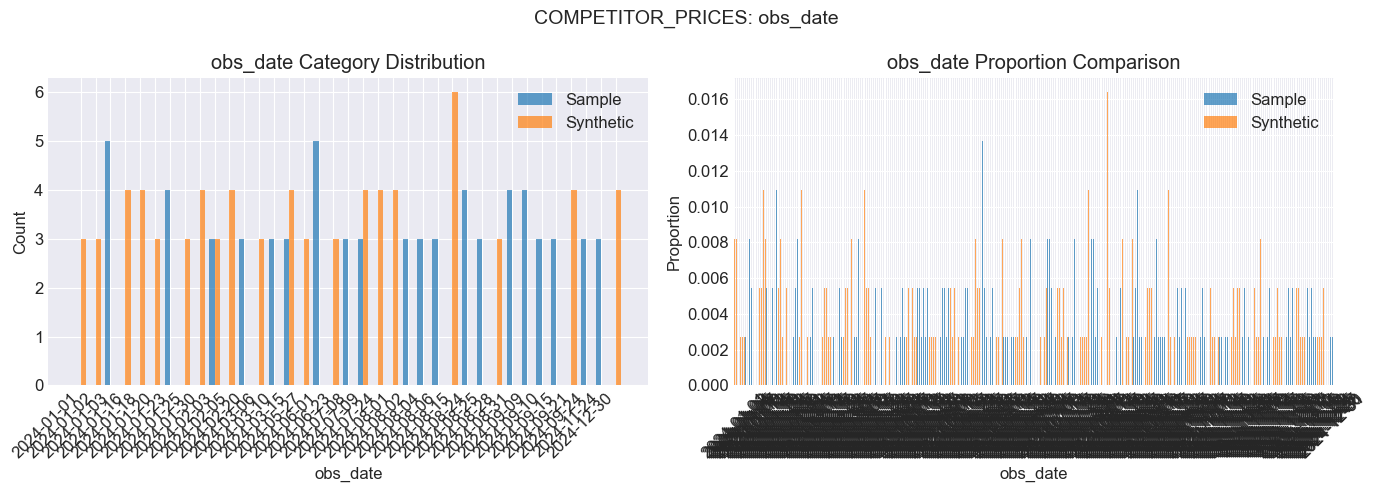

In [4]:
def plot_distribution_comparison(synthetic_df, sample_df, column, table_name):
    """Plot distribution comparison between synthetic and sample data."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Determine if numeric or categorical
    is_numeric = pd.api.types.is_numeric_dtype(synthetic_df[column])
    
    if is_numeric:
        # Histogram for numeric data
        axes[0].hist(sample_df[column].dropna(), bins=30, alpha=0.7, label='Sample', color='blue', density=True)
        axes[0].hist(synthetic_df[column].dropna(), bins=30, alpha=0.7, label='Synthetic', color='orange', density=True)
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Density')
        axes[0].legend()
        axes[0].set_title(f'{column} Distribution Comparison')
        
        # Q-Q plot
        sample_sorted = np.sort(sample_df[column].dropna())
        synthetic_sorted = np.sort(synthetic_df[column].dropna())
        
        # Ensure same length for Q-Q plot
        min_len = min(len(sample_sorted), len(synthetic_sorted))
        sample_quantiles = np.percentile(sample_sorted, np.linspace(0, 100, min_len))
        synthetic_quantiles = np.percentile(synthetic_sorted, np.linspace(0, 100, min_len))
        
        axes[1].scatter(sample_quantiles, synthetic_quantiles, alpha=0.5)
        axes[1].plot([sample_quantiles.min(), sample_quantiles.max()], 
                     [sample_quantiles.min(), sample_quantiles.max()], 
                     'r--', label='Perfect match')
        axes[1].set_xlabel('Sample Quantiles')
        axes[1].set_ylabel('Synthetic Quantiles')
        axes[1].legend()
        axes[1].set_title(f'{column} Q-Q Plot')
    else:
        # Bar plot for categorical data
        sample_counts = sample_df[column].value_counts().head(20)
        synthetic_counts = synthetic_df[column].value_counts().head(20)
        
        # Align categories
        all_categories = sorted(set(sample_counts.index) | set(synthetic_counts.index))
        
        x = np.arange(len(all_categories))
        width = 0.35
        
        sample_values = [sample_counts.get(cat, 0) for cat in all_categories]
        synthetic_values = [synthetic_counts.get(cat, 0) for cat in all_categories]
        
        axes[0].bar(x - width/2, sample_values, width, label='Sample', alpha=0.7)
        axes[0].bar(x + width/2, synthetic_values, width, label='Synthetic', alpha=0.7)
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Count')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(all_categories, rotation=45, ha='right')
        axes[0].legend()
        axes[0].set_title(f'{column} Category Distribution')
        
        # Proportion comparison
        sample_props = sample_df[column].value_counts(normalize=True)
        synthetic_props = synthetic_df[column].value_counts(normalize=True)
        
        comparison_df = pd.DataFrame({
            'Sample': sample_props,
            'Synthetic': synthetic_props
        }).fillna(0)
        
        comparison_df.plot(kind='bar', ax=axes[1], alpha=0.7)
        axes[1].set_ylabel('Proportion')
        axes[1].set_title(f'{column} Proportion Comparison')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{table_name.upper()}: {column}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Compare distributions for tables where we have both synthetic and sample data
for table_name in sample_data.keys():
    if table_name in synthetic_data:
        print(f"\n\n{'='*60}")
        print(f"Comparing {table_name.upper()}")
        print(f"{'='*60}")
        
        synthetic_df = synthetic_data[table_name]
        sample_df = sample_data[table_name]
        
        # Find common columns
        common_columns = set(synthetic_df.columns) & set(sample_df.columns)
        
        # Select key columns to compare (limit to avoid too many plots)
        key_columns = list(common_columns)[:3]  # Compare first 3 common columns
        
        for column in key_columns:
            plot_distribution_comparison(synthetic_df, sample_df, column, table_name)

## 4. Statistical Tests for Distribution Similarity

In [5]:
def perform_statistical_tests(synthetic_df, sample_df, table_name):
    """Perform statistical tests to compare distributions."""
    results = {}
    
    print(f"\n{'='*60}")
    print(f"Statistical Tests for {table_name.upper()}")
    print(f"{'='*60}")
    
    # Find common columns
    common_columns = set(synthetic_df.columns) & set(sample_df.columns)
    
    # Numeric columns
    numeric_cols = synthetic_df[list(common_columns)].select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 0:
        print("\nKolmogorov-Smirnov Test Results (Numeric Columns):")
        print(f"{'Column':<20} {'KS Statistic':<15} {'P-Value':<15} {'Similar?':<10}")
        print("-" * 60)
        
        for column in numeric_cols:
            # Remove NaN values
            synthetic_values = synthetic_df[column].dropna()
            sample_values = sample_df[column].dropna()
            
            # Perform KS test
            ks_stat, p_value = stats.ks_2samp(sample_values, synthetic_values)
            
            # Determine if distributions are similar (p-value > 0.05)
            similar = "Yes" if p_value > 0.05 else "No"
            
            results[f'{column}_ks'] = {
                'statistic': ks_stat,
                'p_value': p_value,
                'similar': similar
            }
            
            print(f"{column:<20} {ks_stat:<15.4f} {p_value:<15.4f} {similar:<10}")
    
    # Categorical columns
    categorical_cols = synthetic_df[list(common_columns)].select_dtypes(include=['object', 'category']).columns
    
    if len(categorical_cols) > 0:
        print("\n\nChi-Square Test Results (Categorical Columns):")
        print(f"{'Column':<20} {'Chi2 Statistic':<15} {'P-Value':<15} {'Similar?':<10}")
        print("-" * 60)
        
        for column in categorical_cols:
            # Get value counts
            sample_counts = sample_df[column].value_counts()
            synthetic_counts = synthetic_df[column].value_counts()
            
            # Align categories
            all_categories = sorted(set(sample_counts.index) | set(synthetic_counts.index))
            sample_aligned = np.array([sample_counts.get(cat, 0) for cat in all_categories])
            synthetic_aligned = np.array([synthetic_counts.get(cat, 0) for cat in all_categories])
            
            # Normalize to same total for chi-square test
            synthetic_normalized = synthetic_aligned * (sample_aligned.sum() / synthetic_aligned.sum())
            
            # Perform chi-square test
            chi2_stat, p_value = stats.chisquare(synthetic_normalized, sample_aligned)
            
            # Determine if distributions are similar
            similar = "Yes" if p_value > 0.05 else "No"
            
            results[f'{column}_chi2'] = {
                'statistic': chi2_stat,
                'p_value': p_value,
                'similar': similar
            }
            
            print(f"{column:<20} {chi2_stat:<15.4f} {p_value:<15.4f} {similar:<10}")
    
    return results

# Perform tests for all tables with sample data
all_test_results = {}
for table_name in sample_data.keys():
    if table_name in synthetic_data:
        test_results = perform_statistical_tests(
            synthetic_data[table_name], 
            sample_data[table_name], 
            table_name
        )
        all_test_results[table_name] = test_results


Statistical Tests for USERS

Kolmogorov-Smirnov Test Results (Numeric Columns):
Column               KS Statistic    P-Value         Similar?  
------------------------------------------------------------
home_location_id     0.0059          0.8751          Yes       
user_id              0.9987          0.0000          No        


Chi-Square Test Results (Categorical Columns):
Column               Chi2 Statistic  P-Value         Similar?  
------------------------------------------------------------
segment              3.2183          0.5220          Yes       

Statistical Tests for SEARCHES

Kolmogorov-Smirnov Test Results (Numeric Columns):
Column               KS Statistic    P-Value         Similar?  
------------------------------------------------------------
month                0.1122          0.0000          No        
location_id          0.0055          0.3468          Yes       
hour                 0.0449          0.0000          No        
search_id            0.9966

## 5. SDV Quality Metrics

In [6]:
def evaluate_sdv_quality(synthetic_df, sample_df, table_name):
    """Evaluate synthetic data quality using SDV metrics."""
    print(f"\n{'='*60}")
    print(f"SDV Quality Metrics for {table_name.upper()}")
    print(f"{'='*60}")
    
    # Create metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(sample_df)
    
    # Basic quality evaluation
    try:
        quality_score = evaluate_quality(
            real_data=sample_df,
            synthetic_data=synthetic_df,
            metadata=metadata
        )
        print(f"\nOverall Quality Score: {quality_score:.2%}")
    except Exception as e:
        print(f"\nError evaluating overall quality: {e}")
        quality_score = None
    
    # Detailed metrics
    metrics_results = {}
    
    # Select numeric columns for correlation analysis
    numeric_cols = sample_df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 1:
        try:
            # Correlation Similarity
            corr_similarity = CorrelationSimilarity.compute(
                real_data=sample_df[numeric_cols],
                synthetic_data=synthetic_df[numeric_cols]
            )
            metrics_results['correlation_similarity'] = corr_similarity
            print(f"\nCorrelation Similarity: {corr_similarity:.4f}")
        except Exception as e:
            print(f"\nError computing correlation similarity: {e}")
    
    # KS Complement (overall)
    try:
        ks_complement = KSComplement.compute(
            real_data=sample_df,
            synthetic_data=synthetic_df
        )
        metrics_results['ks_complement'] = ks_complement
        print(f"KS Complement Score: {ks_complement:.4f}")
    except Exception as e:
        print(f"Error computing KS complement: {e}")
    
    # Total Variation Complement
    try:
        tv_complement = TVComplement.compute(
            real_data=sample_df,
            synthetic_data=synthetic_df
        )
        metrics_results['tv_complement'] = tv_complement
        print(f"TV Complement Score: {tv_complement:.4f}")
    except Exception as e:
        print(f"Error computing TV complement: {e}")
    
    # Range Coverage for numeric columns
    if len(numeric_cols) > 0:
        try:
            range_coverage = RangeCoverage.compute(
                real_data=sample_df,
                synthetic_data=synthetic_df
            )
            metrics_results['range_coverage'] = range_coverage
            print(f"\nRange Coverage: {range_coverage:.4f}")
        except Exception as e:
            print(f"\nError computing range coverage: {e}")
    
    # Boundary Adherence
    try:
        boundary_adherence = BoundaryAdherence.compute(
            real_data=sample_df,
            synthetic_data=synthetic_df
        )
        metrics_results['boundary_adherence'] = boundary_adherence
        print(f"Boundary Adherence: {boundary_adherence:.4f}")
    except Exception as e:
        print(f"Error computing boundary adherence: {e}")
    
    return quality_score, metrics_results

# Evaluate SDV quality for all tables with sample data
sdv_results = {}
for table_name in sample_data.keys():
    if table_name in synthetic_data:
        quality_score, metrics = evaluate_sdv_quality(
            synthetic_data[table_name], 
            sample_data[table_name], 
            table_name
        )
        sdv_results[table_name] = {
            'quality_score': quality_score,
            'metrics': metrics
        }


SDV Quality Metrics for USERS
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 203.51it/s]|
Column Shapes Score: 99.55%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 528.63it/s]|
Column Pair Trends Score: nan%

Overall Score (Average): 99.55%


Error evaluating overall quality: unsupported format string passed to QualityReport.__format__

Correlation Similarity: 0.9984
KS Complement Score: 0.4977
TV Complement Score: 0.9955

Range Coverage: 0.9858
Boundary Adherence: 0.5007

SDV Quality Metrics for SEARCHES
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 64.90it/s]|
Column Shapes Score: 97.04%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 87.29it/s]| 
Column Pair Trends Score: 86.32%

Overall Score (Average): 91.68%


Error evaluating overall quality: unsupported format string passed to QualityReport.__format__

Correlation Similarity: 0.9449
KS Complement Score

## 6. Correlation Analysis

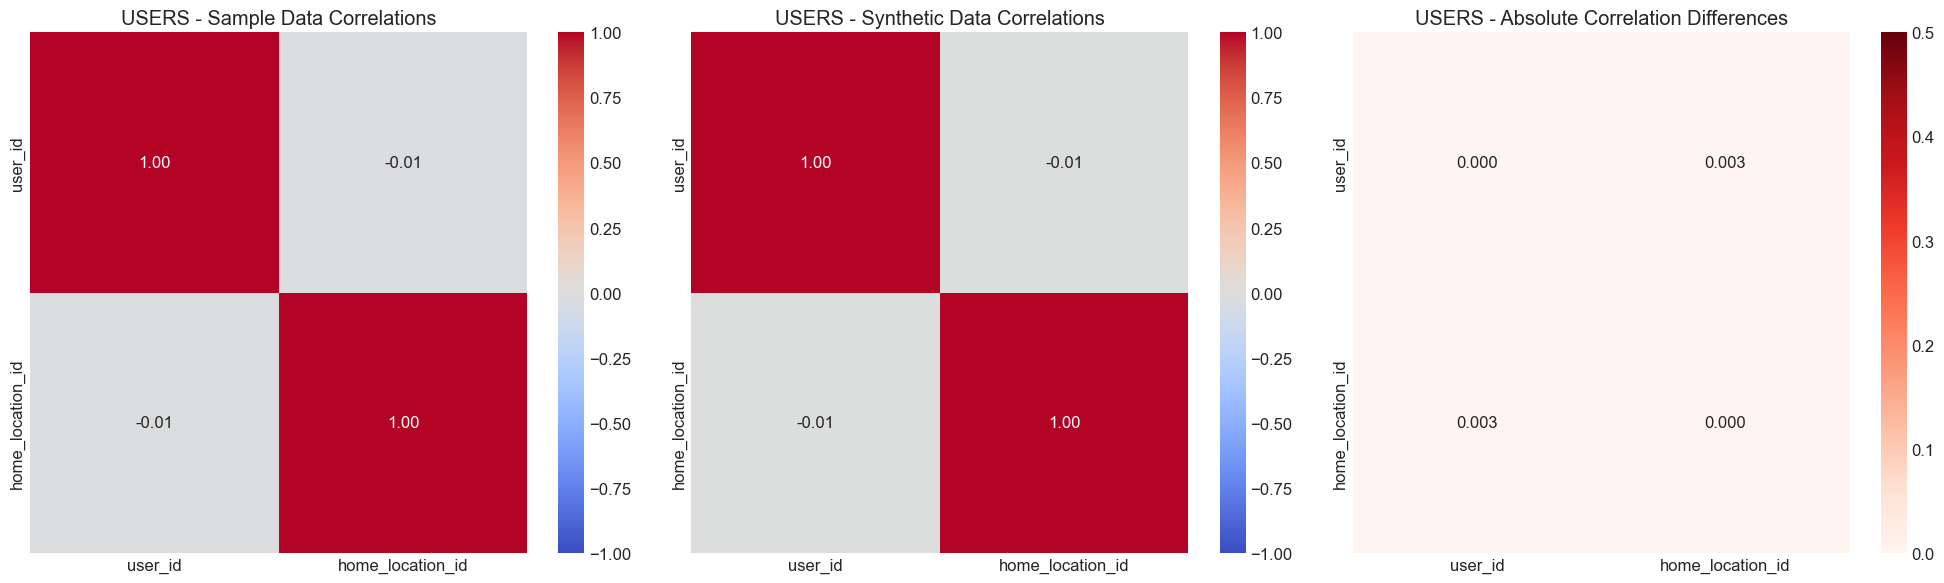


Correlation Analysis Summary for USERS:
  Mean absolute difference: 0.0031
  Max absolute difference: 0.0031
  Std of differences: 0.0000
  Correlations preserved (within 0.1): 100.0%


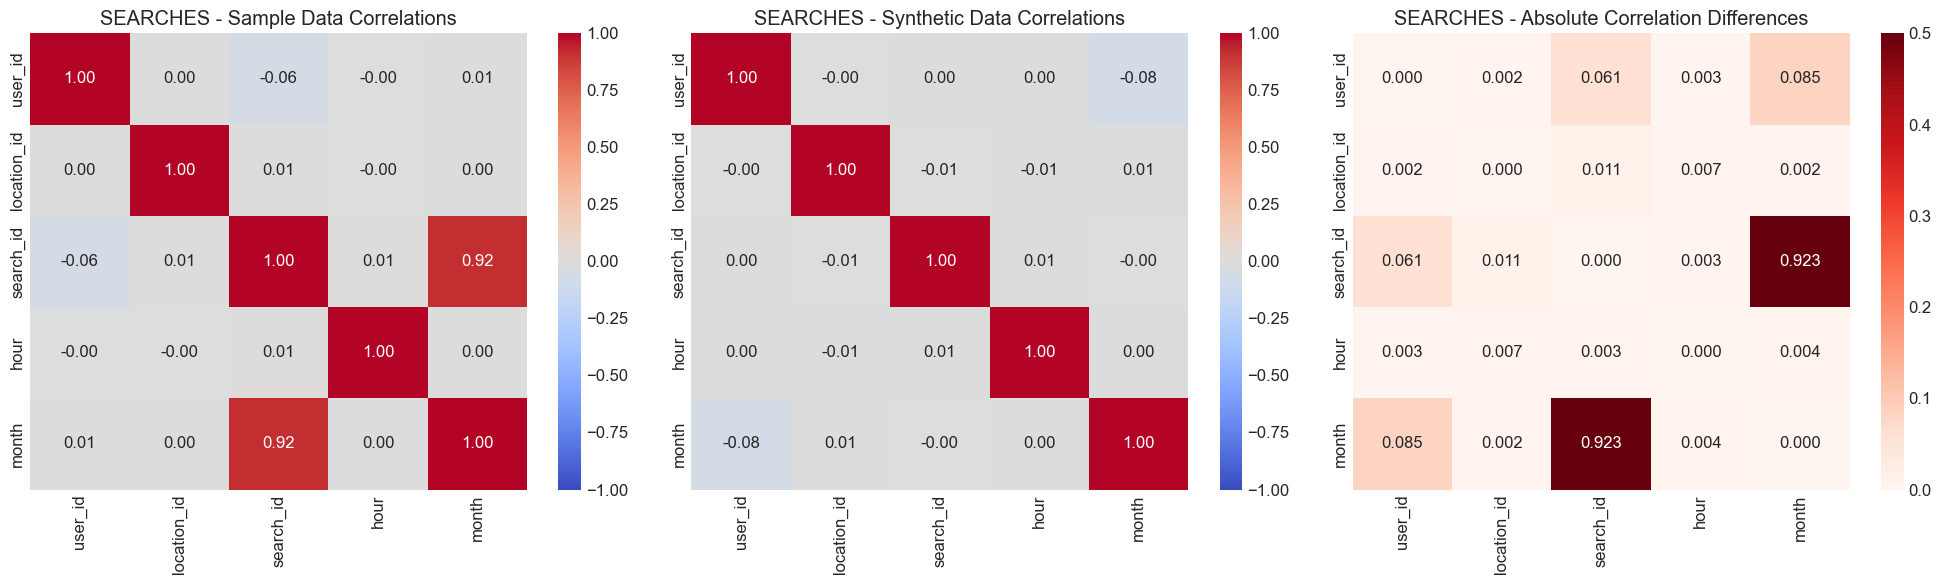


Correlation Analysis Summary for SEARCHES:
  Mean absolute difference: 0.1102
  Max absolute difference: 0.9234
  Std of differences: 0.2725
  Correlations preserved (within 0.1): 90.0%


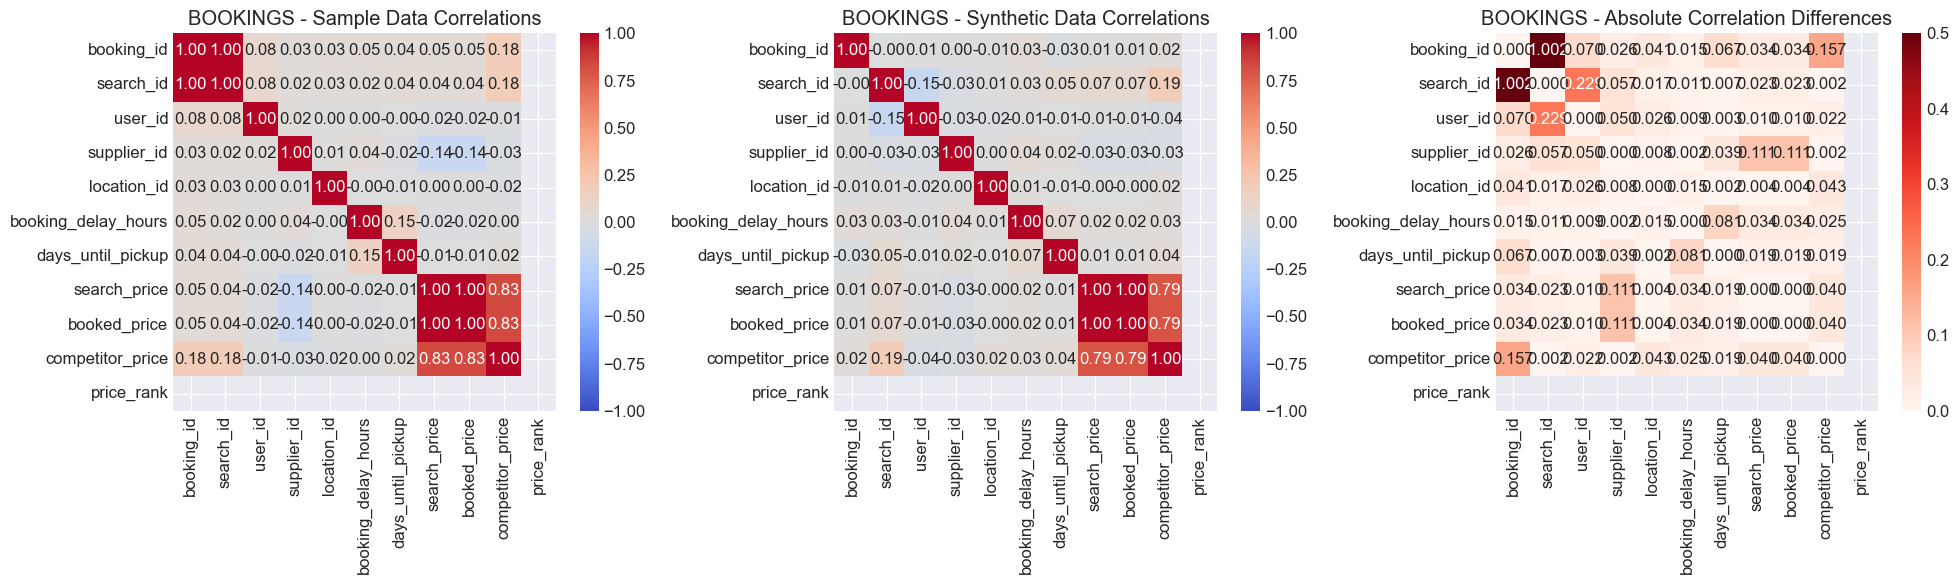


Correlation Analysis Summary for BOOKINGS:
  Mean absolute difference: nan
  Max absolute difference: nan
  Std of differences: nan
  Correlations preserved (within 0.1): 72.7%


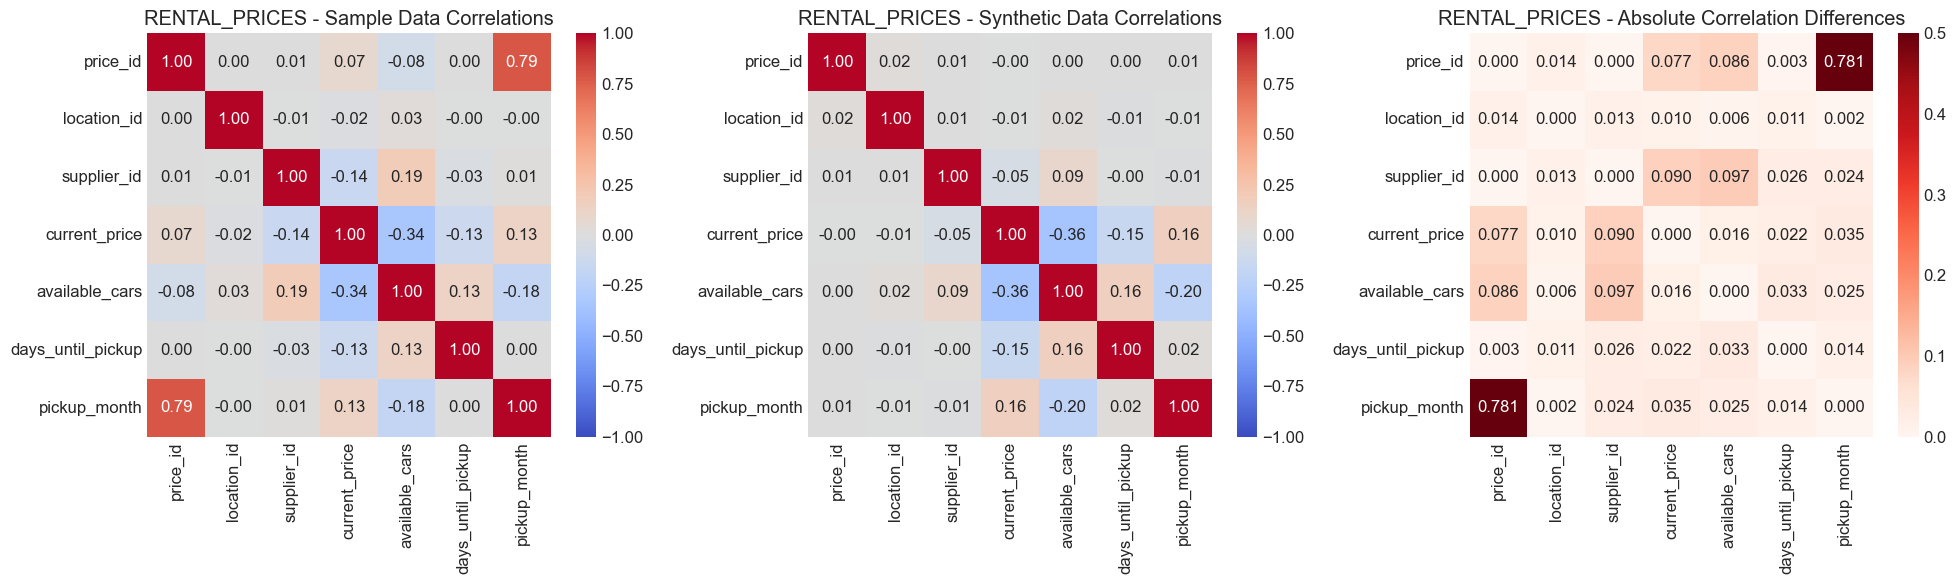


Correlation Analysis Summary for RENTAL_PRICES:
  Mean absolute difference: 0.0659
  Max absolute difference: 0.7809
  Std of differences: 0.1626
  Correlations preserved (within 0.1): 95.2%


In [7]:
def analyze_correlations(synthetic_df, sample_df, table_name):
    """Analyze and compare correlations between synthetic and sample data."""
    # Select numeric columns
    numeric_cols = sample_df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col in synthetic_df.columns]
    
    if len(numeric_cols) < 2:
        print(f"\nNot enough numeric columns in {table_name} for correlation analysis")
        return None
    
    # Compute correlation matrices
    sample_corr = sample_df[numeric_cols].corr()
    synthetic_corr = synthetic_df[numeric_cols].corr()
    
    # Calculate difference
    corr_diff = np.abs(sample_corr - synthetic_corr)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Sample correlation
    sns.heatmap(sample_corr, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, ax=axes[0], fmt='.2f')
    axes[0].set_title(f'{table_name.upper()} - Sample Data Correlations')
    
    # Synthetic correlation
    sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, ax=axes[1], fmt='.2f')
    axes[1].set_title(f'{table_name.upper()} - Synthetic Data Correlations')
    
    # Difference
    sns.heatmap(corr_diff, annot=True, cmap='Reds', vmin=0, vmax=0.5, 
                ax=axes[2], fmt='.3f')
    axes[2].set_title(f'{table_name.upper()} - Absolute Correlation Differences')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics
    upper_triangle_indices = np.triu_indices_from(corr_diff, k=1)
    differences = corr_diff.values[upper_triangle_indices]
    
    stats = {
        'mean_abs_diff': np.mean(differences),
        'max_abs_diff': np.max(differences),
        'std_abs_diff': np.std(differences),
        'correlations_preserved': (differences < 0.1).sum() / len(differences)  # % within 0.1
    }
    
    print(f"\nCorrelation Analysis Summary for {table_name.upper()}:")
    print(f"  Mean absolute difference: {stats['mean_abs_diff']:.4f}")
    print(f"  Max absolute difference: {stats['max_abs_diff']:.4f}")
    print(f"  Std of differences: {stats['std_abs_diff']:.4f}")
    print(f"  Correlations preserved (within 0.1): {stats['correlations_preserved']:.1%}")
    
    return stats

# Analyze correlations for key tables
correlation_results = {}
for table_name in ['users', 'searches', 'bookings', 'rental_prices']:
    if table_name in sample_data and table_name in synthetic_data:
        corr_stats = analyze_correlations(
            synthetic_data[table_name], 
            sample_data[table_name], 
            table_name
        )
        if corr_stats:
            correlation_results[table_name] = corr_stats

## 7. Temporal Pattern Analysis

For time-series data like searches and bookings, we need to verify temporal patterns are preserved.


Temporal Pattern Analysis for SEARCHES


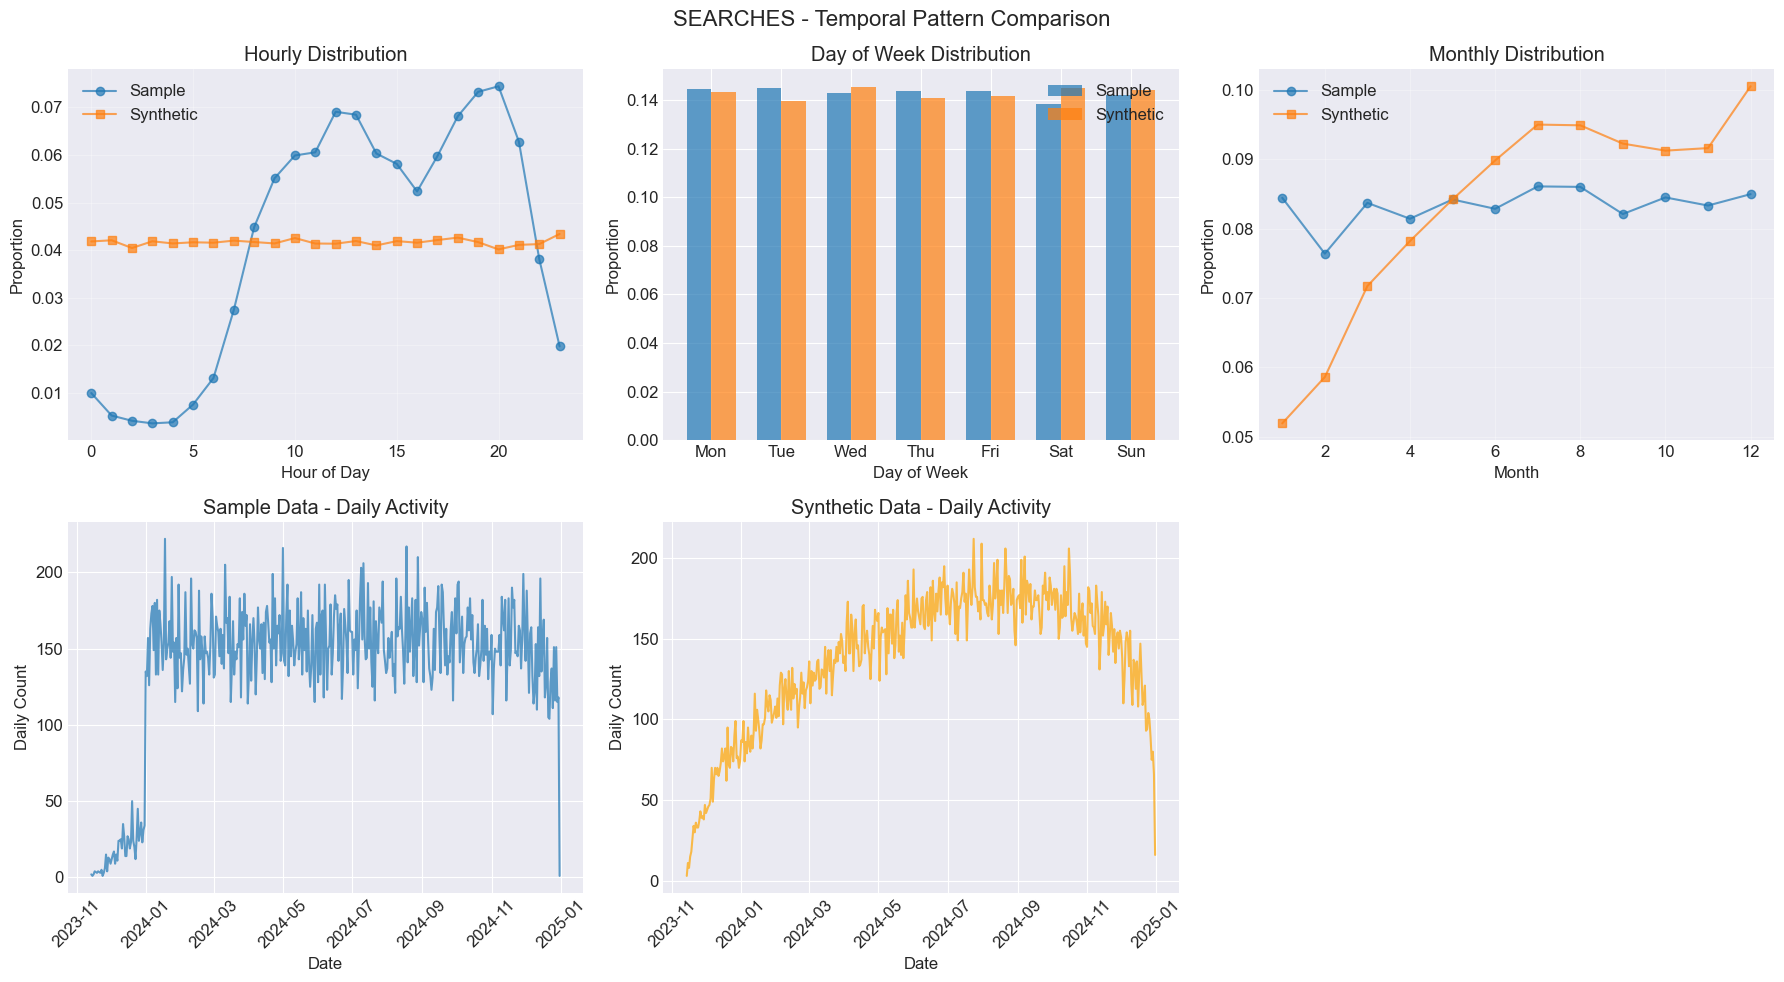


Temporal Pattern Analysis for BOOKINGS


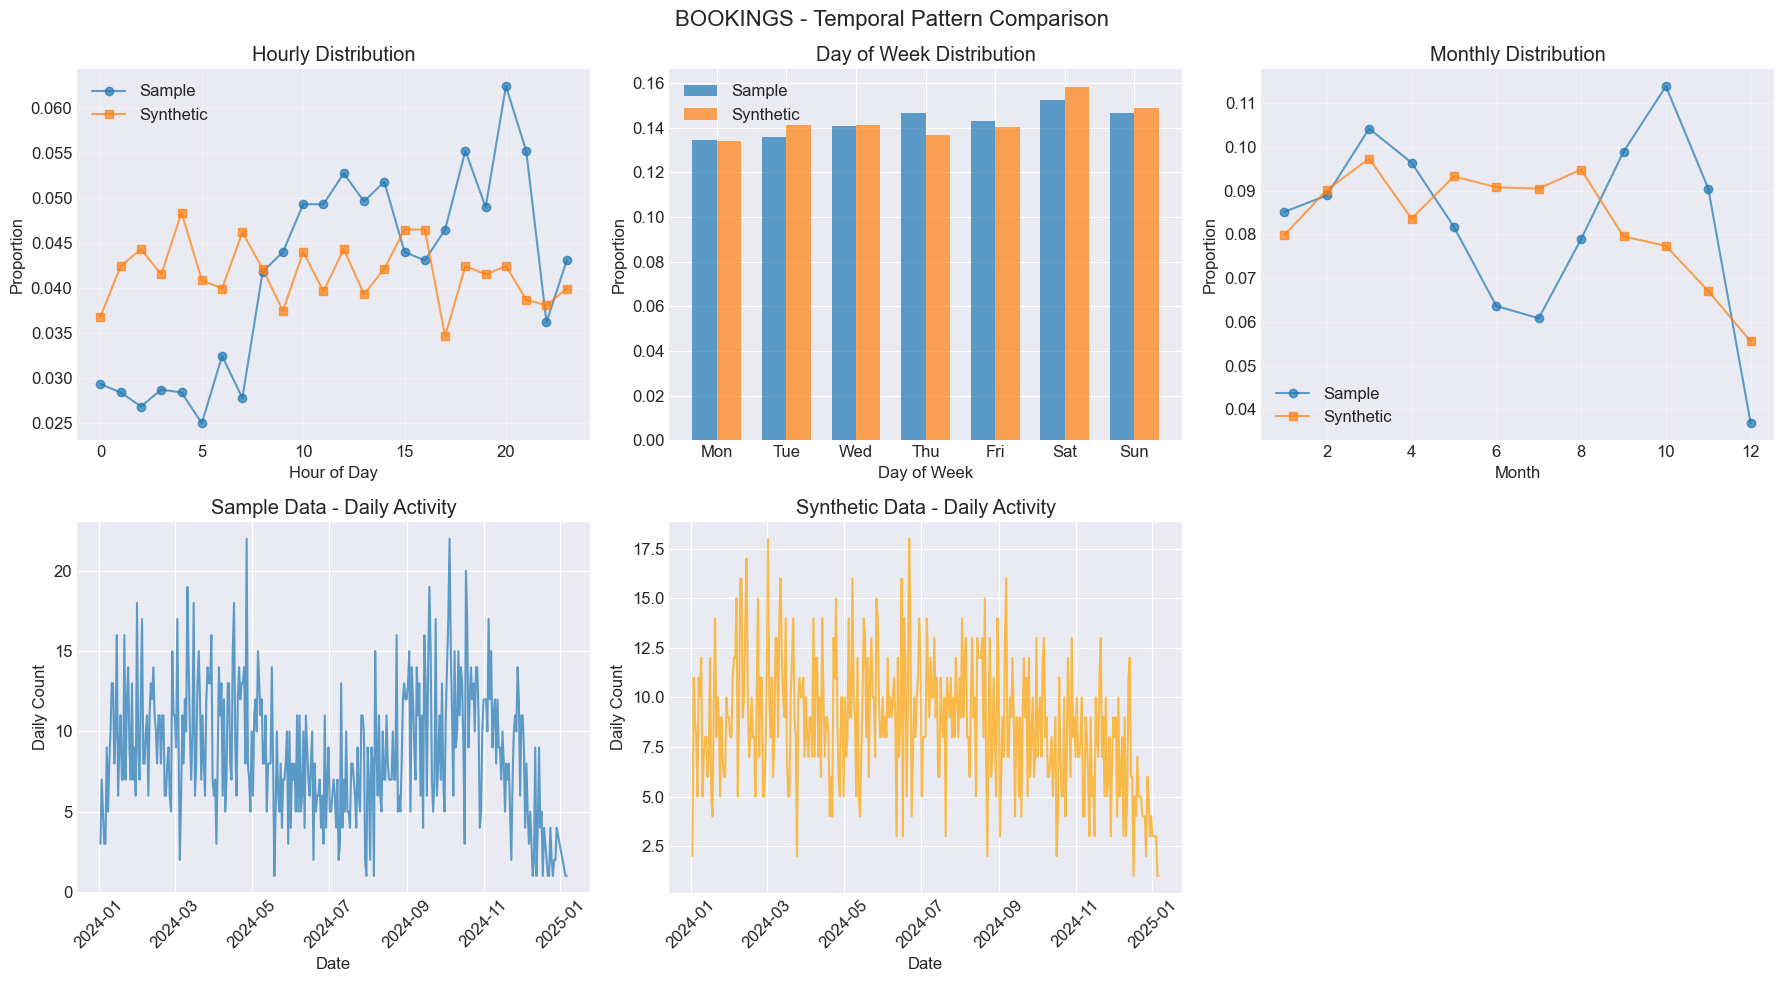


Temporal Pattern Analysis for RENTAL_PRICES


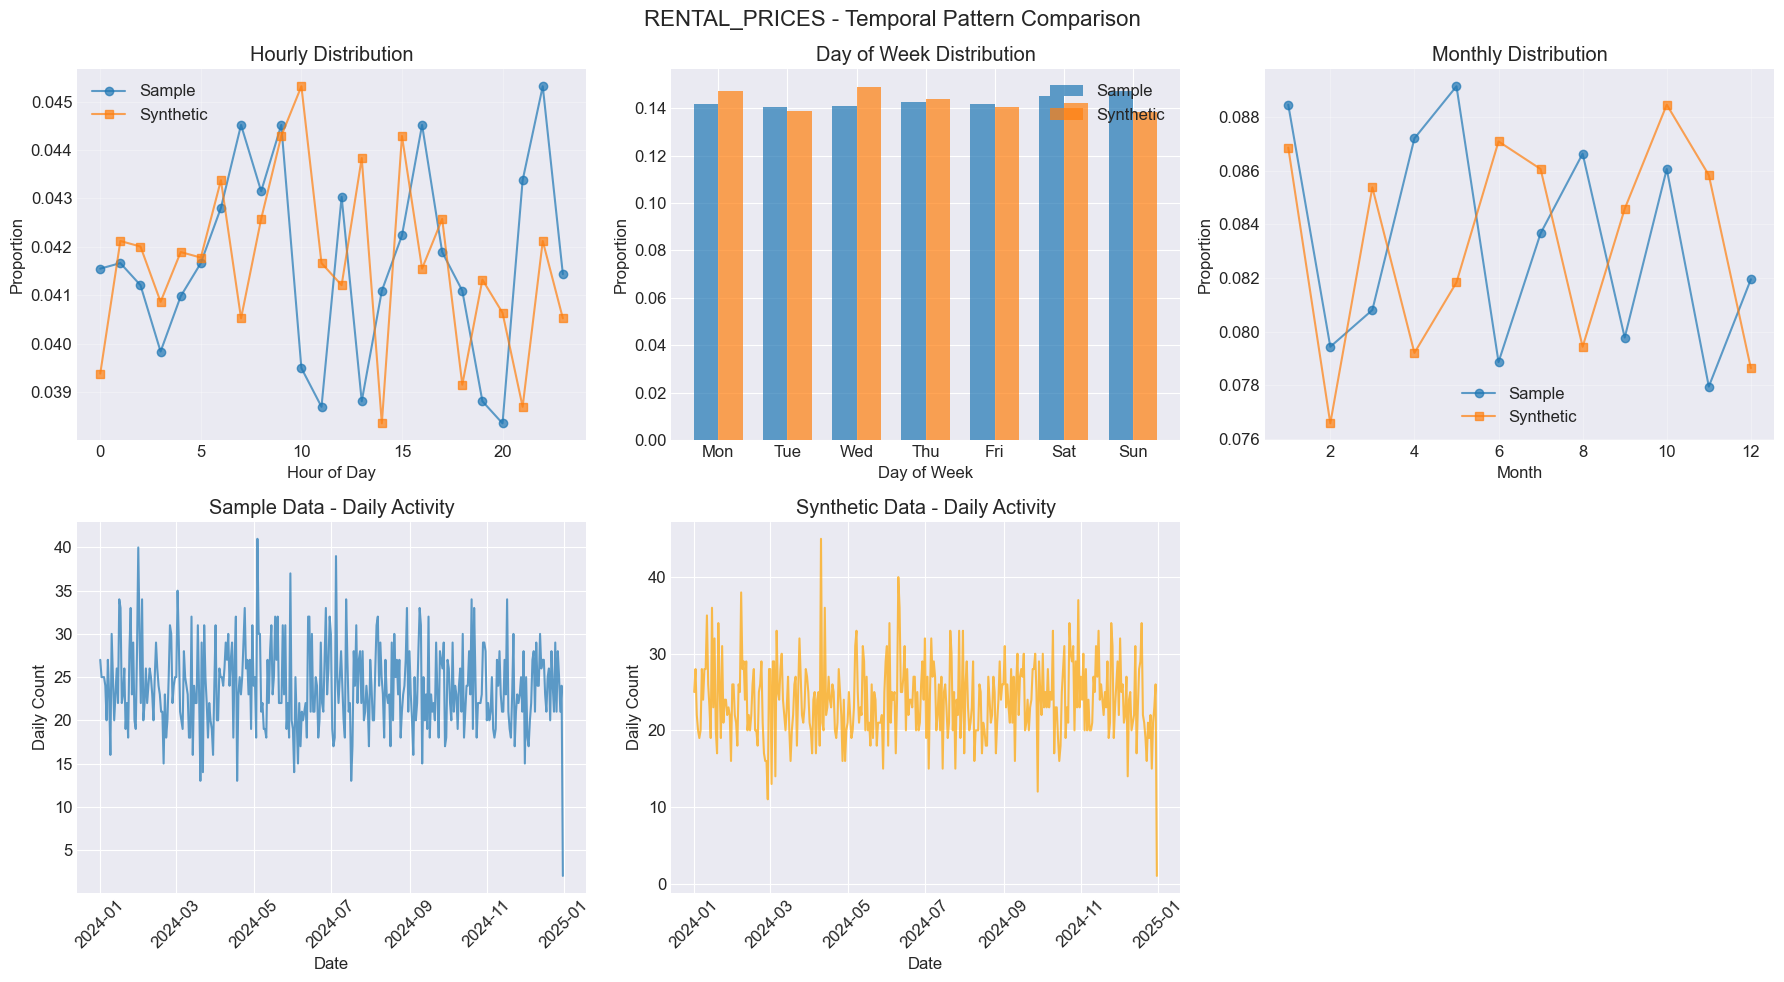

In [8]:
def analyze_temporal_patterns(synthetic_df, sample_df, table_name, date_column):
    """Analyze temporal patterns in the data."""
    print(f"\n{'='*60}")
    print(f"Temporal Pattern Analysis for {table_name.upper()}")
    print(f"{'='*60}")
    
    # Convert to datetime
    synthetic_df[date_column] = pd.to_datetime(synthetic_df[date_column])
    sample_df[date_column] = pd.to_datetime(sample_df[date_column])
    
    # Extract temporal features
    for df, label in [(sample_df, 'Sample'), (synthetic_df, 'Synthetic')]:
        df['hour'] = df[date_column].dt.hour
        df['day_of_week'] = df[date_column].dt.dayofweek
        df['month'] = df[date_column].dt.month
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Hourly distribution
    sample_hourly = sample_df['hour'].value_counts(normalize=True).sort_index()
    synthetic_hourly = synthetic_df['hour'].value_counts(normalize=True).sort_index()
    
    axes[0, 0].plot(sample_hourly.index, sample_hourly.values, 'o-', label='Sample', alpha=0.7)
    axes[0, 0].plot(synthetic_hourly.index, synthetic_hourly.values, 's-', label='Synthetic', alpha=0.7)
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Proportion')
    axes[0, 0].set_title('Hourly Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Day of week distribution
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    sample_dow = sample_df['day_of_week'].value_counts(normalize=True).sort_index()
    synthetic_dow = synthetic_df['day_of_week'].value_counts(normalize=True).sort_index()
    
    x = np.arange(7)
    width = 0.35
    axes[0, 1].bar(x - width/2, sample_dow.values, width, label='Sample', alpha=0.7)
    axes[0, 1].bar(x + width/2, synthetic_dow.values, width, label='Synthetic', alpha=0.7)
    axes[0, 1].set_xlabel('Day of Week')
    axes[0, 1].set_ylabel('Proportion')
    axes[0, 1].set_title('Day of Week Distribution')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(days)
    axes[0, 1].legend()
    
    # Monthly distribution
    sample_monthly = sample_df['month'].value_counts(normalize=True).sort_index()
    synthetic_monthly = synthetic_df['month'].value_counts(normalize=True).sort_index()
    
    axes[0, 2].plot(sample_monthly.index, sample_monthly.values, 'o-', label='Sample', alpha=0.7)
    axes[0, 2].plot(synthetic_monthly.index, synthetic_monthly.values, 's-', label='Synthetic', alpha=0.7)
    axes[0, 2].set_xlabel('Month')
    axes[0, 2].set_ylabel('Proportion')
    axes[0, 2].set_title('Monthly Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Time series plot (daily counts)
    sample_daily = sample_df.groupby(sample_df[date_column].dt.date).size()
    synthetic_daily = synthetic_df.groupby(synthetic_df[date_column].dt.date).size()
    
    axes[1, 0].plot(sample_daily.index, sample_daily.values, alpha=0.7, label='Sample')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Daily Count')
    axes[1, 0].set_title('Sample Data - Daily Activity')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    axes[1, 1].plot(synthetic_daily.index, synthetic_daily.values, alpha=0.7, label='Synthetic', color='orange')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Daily Count')
    axes[1, 1].set_title('Synthetic Data - Daily Activity')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Remove the empty subplot
    fig.delaxes(axes[1, 2])
    
    plt.suptitle(f'{table_name.upper()} - Temporal Pattern Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

# Analyze temporal patterns for relevant tables
temporal_tables = {
    'searches': 'search_ts',
    'bookings': 'booking_ts',
    'rental_prices': 'obs_ts'
}

for table_name, date_col in temporal_tables.items():
    if table_name in sample_data and table_name in synthetic_data:
        if date_col in sample_data[table_name].columns:
            analyze_temporal_patterns(
                synthetic_data[table_name].copy(), 
                sample_data[table_name].copy(), 
                table_name, 
                date_col
            )

## 8. Data Relationships and Integrity

In [9]:
def check_referential_integrity(data_dict):
    """Check referential integrity in the synthetic data."""
    print("\n" + "="*60)
    print("Referential Integrity Check")
    print("="*60)
    
    integrity_issues = []
    
    # Check 1: All booking user_ids exist in users table
    if 'users' in data_dict and 'bookings' in data_dict:
        user_ids = set(data_dict['users']['user_id'])
        booking_user_ids = set(data_dict['bookings']['user_id'])
        
        orphan_bookings = booking_user_ids - user_ids
        if orphan_bookings:
            integrity_issues.append(f"Found {len(orphan_bookings)} bookings with non-existent user_ids")
        else:
            print("✅ All booking user_ids exist in users table")
    
    # Check 2: All search user_ids exist in users table
    if 'users' in data_dict and 'searches' in data_dict:
        search_user_ids = set(data_dict['searches']['user_id'])
        
        orphan_searches = search_user_ids - user_ids
        if orphan_searches:
            integrity_issues.append(f"Found {len(orphan_searches)} searches with non-existent user_ids")
        else:
            print("✅ All search user_ids exist in users table")
    
    # Check 3: All booking search_ids exist in searches table
    if 'searches' in data_dict and 'bookings' in data_dict:
        search_ids = set(data_dict['searches']['search_id'])
        booking_search_ids = set(data_dict['bookings']['search_id'])
        
        orphan_booking_searches = booking_search_ids - search_ids
        if orphan_booking_searches:
            integrity_issues.append(f"Found {len(orphan_booking_searches)} bookings with non-existent search_ids")
        else:
            print("✅ All booking search_ids exist in searches table")
    
    # Check 4: Location consistency
    if 'locations' in data_dict:
        location_ids = set(data_dict['locations']['location_id'])
        
        # Check in searches
        if 'searches' in data_dict:
            search_location_ids = set(data_dict['searches']['location_id'])
            invalid_search_locations = search_location_ids - location_ids
            if invalid_search_locations:
                integrity_issues.append(f"Found {len(invalid_search_locations)} searches with invalid location_ids")
            else:
                print("✅ All search location_ids are valid")
    
    # Check 5: Supplier consistency
    if 'suppliers' in data_dict:
        supplier_ids = set(data_dict['suppliers']['supplier_id'].unique())
        
        # Check in bookings
        if 'bookings' in data_dict:
            booking_supplier_ids = set(data_dict['bookings']['supplier_id'])
            invalid_booking_suppliers = booking_supplier_ids - supplier_ids
            if invalid_booking_suppliers:
                integrity_issues.append(f"Found {len(invalid_booking_suppliers)} bookings with invalid supplier_ids")
            else:
                print("✅ All booking supplier_ids are valid")
    
    # Summary
    if integrity_issues:
        print("\n❌ Integrity Issues Found:")
        for issue in integrity_issues:
            print(f"   - {issue}")
    else:
        print("\n✅ All referential integrity checks passed!")
    
    return integrity_issues

# Check referential integrity
integrity_issues = check_referential_integrity(synthetic_data)


Referential Integrity Check
✅ All booking supplier_ids are valid

❌ Integrity Issues Found:
   - Found 1087 bookings with non-existent user_ids
   - Found 11933 searches with non-existent user_ids
   - Found 2001 bookings with non-existent search_ids
   - Found 24 searches with invalid location_ids


## 9. Summary and Optimization Recommendations

In [10]:
def generate_summary_report():
    """Generate a comprehensive summary report with recommendations."""
    print("\n" + "="*80)
    print("SYNTHETIC DATA QUALITY SUMMARY REPORT")
    print("="*80)
    
    # 1. Overall Quality Scores
    print("\n1. OVERALL QUALITY SCORES:")
    print("-" * 40)
    
    if sdv_results:
        for table_name, results in sdv_results.items():
            if results['quality_score']:
                print(f"   {table_name}: {results['quality_score']:.2%}")
                
                # Key metrics
                if 'correlation_similarity' in results['metrics']:
                    print(f"     - Correlation Similarity: {results['metrics']['correlation_similarity']:.4f}")
                if 'range_coverage' in results['metrics']:
                    print(f"     - Range Coverage: {results['metrics']['range_coverage']:.4f}")
    
    # 2. Statistical Test Summary
    print("\n2. STATISTICAL TEST SUMMARY:")
    print("-" * 40)
    
    if all_test_results:
        total_tests = 0
        passed_tests = 0
        
        for table_name, test_results in all_test_results.items():
            table_passed = 0
            table_total = 0
            
            for test_name, result in test_results.items():
                total_tests += 1
                table_total += 1
                if result['similar'] == 'Yes':
                    passed_tests += 1
                    table_passed += 1
            
            print(f"   {table_name}: {table_passed}/{table_total} tests passed ({table_passed/table_total:.1%})")
        
        print(f"\n   Overall: {passed_tests}/{total_tests} tests passed ({passed_tests/total_tests:.1%})")
    
    # 3. Correlation Preservation
    print("\n3. CORRELATION PRESERVATION:")
    print("-" * 40)
    
    if correlation_results:
        for table_name, stats in correlation_results.items():
            print(f"   {table_name}:")
            print(f"     - Mean correlation difference: {stats['mean_abs_diff']:.4f}")
            print(f"     - Correlations preserved: {stats['correlations_preserved']:.1%}")
    
    # 4. Data Integrity
    print("\n4. DATA INTEGRITY:")
    print("-" * 40)
    
    if not integrity_issues:
        print("   ✅ All referential integrity checks passed")
    else:
        print(f"   ❌ Found {len(integrity_issues)} integrity issues")
    
    # 5. Optimization Recommendations
    print("\n5. OPTIMIZATION RECOMMENDATIONS:")
    print("-" * 40)
    
    recommendations = []
    
    # Check quality scores
    if sdv_results:
        low_quality_tables = []
        for table_name, results in sdv_results.items():
            if results['quality_score'] and results['quality_score'] < 0.8:
                low_quality_tables.append(table_name)
        
        if low_quality_tables:
            recommendations.append(
                f"Tables with quality < 80%: {', '.join(low_quality_tables)}. "
                "Consider using CTGANSynthesizer or TVAESynthesizer for better quality."
            )
    
    # Check correlation preservation
    if correlation_results:
        poor_correlation_tables = []
        for table_name, stats in correlation_results.items():
            if stats['correlations_preserved'] < 0.8:
                poor_correlation_tables.append(table_name)
        
        if poor_correlation_tables:
            recommendations.append(
                f"Tables with poor correlation preservation: {', '.join(poor_correlation_tables)}. "
                "Consider using enforce_min_max_values=True and adjusting numerical_distributions."
            )
    
    # Check statistical tests
    if all_test_results:
        failed_distribution_columns = []
        for table_name, test_results in all_test_results.items():
            for test_name, result in test_results.items():
                if result['similar'] == 'No':
                    column_name = test_name.split('_')[0]
                    failed_distribution_columns.append(f"{table_name}.{column_name}")
        
        if failed_distribution_columns:
            recommendations.append(
                f"Columns failing distribution tests: {', '.join(failed_distribution_columns[:5])}... "
                "Consider using column-specific distributions (beta for bounded, gamma for skewed)."
            )
    
    # General recommendations
    recommendations.extend([
        "For better temporal patterns: Add date constraints and use conditional sampling.",
        "For categorical data: Consider using CategoricalFuzzyRule constraints.",
        "For privacy: Implement differential privacy with epsilon parameter.",
        "For relationships: Use HMASynthesizer for multi-table synthesis with constraints."
    ])
    
    # Print recommendations
    for i, rec in enumerate(recommendations, 1):
        print(f"\n   {i}. {rec}")
    
    print("\n" + "="*80)

# Generate the summary report
generate_summary_report()


SYNTHETIC DATA QUALITY SUMMARY REPORT

1. OVERALL QUALITY SCORES:
----------------------------------------

2. STATISTICAL TEST SUMMARY:
----------------------------------------
   users: 2/3 tests passed (66.7%)
   searches: 6/11 tests passed (54.5%)
   bookings: 8/16 tests passed (50.0%)
   rental_prices: 4/10 tests passed (40.0%)
   competitor_prices: 2/7 tests passed (28.6%)

   Overall: 22/47 tests passed (46.8%)

3. CORRELATION PRESERVATION:
----------------------------------------
   users:
     - Mean correlation difference: 0.0031
     - Correlations preserved: 100.0%
   searches:
     - Mean correlation difference: 0.1102
     - Correlations preserved: 90.0%
   bookings:
     - Mean correlation difference: nan
     - Correlations preserved: 72.7%
   rental_prices:
     - Mean correlation difference: 0.0659
     - Correlations preserved: 95.2%

4. DATA INTEGRITY:
----------------------------------------
   ❌ Found 4 integrity issues

5. OPTIMIZATION RECOMMENDATIONS:
---------

## 10. Export Quality Metrics for Future Reference

In [11]:
# Compile all results into a comprehensive report
quality_report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'synthetic_data_tables': list(synthetic_data.keys()),
    'sample_data_tables': list(sample_data.keys()),
    'sdv_quality_scores': {k: v['quality_score'] for k, v in sdv_results.items() if v['quality_score']},
    'statistical_test_summary': {
        table: {
            'total_tests': len(results),
            'passed_tests': sum(1 for r in results.values() if r['similar'] == 'Yes'),
            'pass_rate': sum(1 for r in results.values() if r['similar'] == 'Yes') / len(results)
        }
        for table, results in all_test_results.items()
    },
    'correlation_analysis': correlation_results,
    'integrity_issues': integrity_issues,
    'recommendations': [
        "Improve quality scores for tables below 80%",
        "Address failed statistical tests",
        "Enhance correlation preservation",
        "Consider multi-table synthesis for relationships"
    ]
}

# Save the report
import json

report_path = base_path / "data" / "synthetic_data_quality_report.json"
with open(report_path, 'w') as f:
    json.dump(quality_report, f, indent=2, default=str)

print(f"\n✅ Quality report saved to: {report_path}")

# Display final summary
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"\nAnalyzed {len(synthetic_data)} synthetic tables")
print(f"Compared with {len(sample_data)} sample tables")
print(f"\nNext steps:")
print("1. Review the quality report and recommendations")
print("2. Optimize SDV synthesizers based on findings")
print("3. Re-generate synthetic data with improved parameters")
print("4. Validate the data is suitable for 'book or wait' prediction model")


✅ Quality report saved to: ../data/synthetic_data_quality_report.json

ANALYSIS COMPLETE

Analyzed 8 synthetic tables
Compared with 5 sample tables

Next steps:
1. Review the quality report and recommendations
2. Optimize SDV synthesizers based on findings
3. Re-generate synthetic data with improved parameters
4. Validate the data is suitable for 'book or wait' prediction model
